# Free Fall

### Introduction

Here, on Earth objects are constantly fall down. Nowadays, students learn about the constant of gravitation (G) and the gravitational acceleration (g) already at school, however, humanity calculated this constants and the equations describing such type motion as falling comperatively recently. 

### What is it?

Free fall is a state at which an object is subjected to the effect of gravitation, that leads to the fall of such object. You might be deceived by the fact that only the heavier objects pull the lighter ones, however, while say Earth pulls the moon closer, the Moon also pulls the Earth closer. So why does the Moon orbit the Earth then and not vice versa? The force of the pull matters, the force projected onto the Moon is drastically larger than that of force projected onto the Earth. 

### Example

What will fall faster, a hummer or a feather? If you have not been asked it before, your most probable answer will be the hummer. But the answer is: "it depends". But what is the dependency? If you apply the formula for the falling object: $y=\frac{1}{2}gt^2$, you will say that the hummer and the feather are going to fall down at the same time, because the equation does not take into account the mass of the object. So why then the hummer falls faster? The answer is the air. Air has density which slows down objects and the smaller the mass and bigger the sufrace of the object the slower it falls. In fact, on Earth, obejcts may reach their maximum velocity called the **terminal velocity**. The feather falls slower than the hummer because it reaches its terminal velocity almost instantly, that means it falls with a constant velocity. In vacuum though, these two objects will fall down as the equation describes. Watch the [video](https://www.youtube.com/watch?v=Oo8TaPVsn9Y) below, where astranauts make this experiment on the Moon (in vacuum, with no air).

### Video of falling object on the Moon (in vacuum)

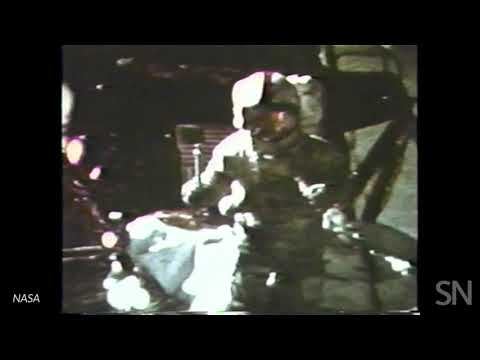

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo("Oo8TaPVsn9Y", width=512)

In this lab you will experiment with the falling objects tweaking the environment (vacuum or not) and the masses of the objects.

# Simulation

### Installing packages (for Google Colab)

If this notebook is opened in Google Colab then some packages must be installed to run the code!

In [1]:
#@title Run to install MuJoCo and `dm_control` for Google Colab

IS_COLAB = 'google.colab' in str(get_ipython())

if IS_COLAB:
    import distutils.util
    import os
    import subprocess
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
            'Cannot communicate with GPU. '
            'Make sure you are using a GPU Colab runtime. '
            'Go to the Runtime menu and select Choose runtime type.')

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write("""{
            "file_format_version" : "1.0.0",
            "ICD" : {
                "library_path" : "libEGL_nvidia.so.0"
            }
        }
        """)

    print('Installing dm_control...')
    !pip install -q dm_control>=1.0.22

    # Configure dm_control to use the EGL rendering backend (requires GPU)
    %env MUJOCO_GL=egl 

    print('Checking that the dm_control installation succeeded...')
    try:
        from dm_control import suite
        env = suite.load('cartpole', 'swingup')
        pixels = env.physics.render()
    except Exception as e:
        raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".')
    else:
        del pixels, suite

    !echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

    # Graphics and plotting.
    print('Installing mediapy:')
    !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
    !pip install -q mediapy

    !git clone https://github.com/commanderxa/extraphi.git

## Import

Import all required packages to preform simulations. Packages include simulation engine, plotting libraries and other ones necessary for computations.

In [2]:
%env MUJOCO_GL=egl

# simulation
from dm_control import mjcf

# for video recording
import mediapy

# computations
import numpy as np

# plot charts
import seaborn as sns
import matplotlib.pyplot as plt

env: MUJOCO_GL=egl


Set nice theme for plots

In [3]:
sns.set_theme(style="whitegrid")

## Initial Conditions

In this block constants are defined. They impact the environment, rendering and objects directly.

In [4]:
# global
viscosity = 0.00002  # Air Resistance
density = 1.2

# simulation constants
blue_mass = 0.1  # mass [kg]
red_mass = 100
distance = 20  # [m]
is_vacuum = True

# rendering
width = 1280
height = 720
dpi = 600
duration = 30  # (seconds)
framerate = 60  # (Hz)

## Model

### Scene

Import scene from `mechanics/scene.py`. The code is a bit difficult due to the import from parent directories.

In [5]:
if not IS_COLAB:
  import os, sys

  module_path = os.path.abspath(os.path.join(".."))
  if module_path not in sys.path:
      sys.path.append(module_path)

  from scene import Scene

else:
  from extraphi.mechanics.scene import Scene

### Objects of Interest

This class defines the object of our interest, a `box`. Here we write what is this object (box), what can it do (move, fall) and also add a camera that follows the object.

In [6]:
class Sphere(object):

    def __init__(self, name: str, size: float, mass: float, rgba: list[float]) -> None:
        self.model = mjcf.RootElement(model=name)

        self.sphere = self.model.worldbody.add("body", name="sphere", pos=[0, 0, 0])
        self.sphere_geom = self.sphere.add(
            "geom",
            name="sphere_geom",
            type="sphere",
            size=[size],
            rgba=rgba,
            mass=mass,
        )

        self.fall = self.sphere.add("joint", name="fall", type="slide", axis=[0, 0, 1])

### World Model

Collecting everything into one general model

In [7]:
class Model(object):

    def __init__(self, blue_mass: float, red_mass: float, distance: float) -> None:
        self.model = mjcf.RootElement(model="model")

        # set render info
        self.model.visual.__getattr__("global").offheight = height
        self.model.visual.__getattr__("global").offwidth = width

        # set the simulation constants
        if not is_vacuum:
            self.model.option.viscosity = viscosity
            self.model.option.density = density

        self.model.option.integrator = "RK4"
        self.model.option.timestep = 0.001

        # create the scene (ground)
        self.scene = Scene(length=10, width=4)
        self.scene_site = self.model.worldbody.add("site", pos=[0, 0, 0])
        self.scene_site.attach(self.scene.model)

        self.spheres = self.model.worldbody.add("body", name="spheres", pos=[0, 0, distance])
        self.camera = self.spheres.add(
            "camera",
            name="front",
            pos=[0, -10, 0],
            euler=[90, 0, 0],
            mode="trackcom",
        )

        # add sphere
        self.sphere = Sphere(
            name="blue_sphere", size=0.5, mass=blue_mass, rgba=[0, 0, 1, 1]
        )
        sphere_site = self.spheres.add("site", pos=[-1, 0, 0])
        sphere_site.attach(self.sphere.model)

        # add sphere
        self.sphere2 = Sphere(
            name="red_sphere", size=0.5, mass=red_mass, rgba=[1, 0, 0, 1]
        )
        sphere_site2 = self.spheres.add("site", pos=[1, 0, 0])
        sphere_site2.attach(self.sphere2.model)

## Simulation

Initializing the `physics` of the simulation

In [8]:
model = Model(blue_mass, red_mass, distance).model
physics = mjcf.Physics.from_mjcf_model(model)

First of all, the environment must be verified by rendering a picture

""

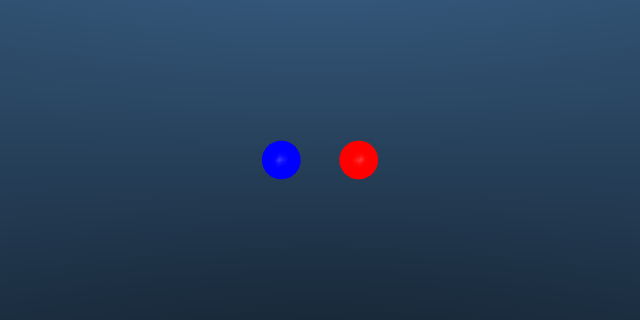

In [9]:
mediapy.show_image(physics.render(height=320, width=640, camera_id=0))

Get IDs of interesting objects

In [11]:
ground_id = physics.model.name2id("scene/platform", "geom")
blue_id = physics.model.name2id("blue_sphere/sphere_geom", "geom")
red_id = physics.model.name2id("red_sphere/sphere_geom", "geom")
ground_id, blue_id, red_id

(0, 1, 2)

### Simulation Loop

In [12]:
physics.named.data.geom_xpos

FieldIndexer(geom_xpos):
                            x         y         z         
0          scene/platform [ 0         0         0       ]
1 blue_sphere/sphere_geom [-1         0         20      ]
2  red_sphere/sphere_geom [ 1         0         20      ]

In [13]:
frames = []
timevals = []

blue_velocity = []
blue_position = []

red_velocity = []
red_position = []

stop = None
while physics.time() < duration:
    physics.step()

    if stop is not None and physics.data.time - stop > 1:
        break

    blue_stop = None
    red_stop = None
    for i, c in enumerate(physics.data.contact):
        if red_id in c.geom and ground_id in c.geom and stop is None:
            red_stop = physics.data.time
        if blue_id in c.geom and ground_id in c.geom and stop is None:
            blue_stop = physics.data.time
    if blue_stop is not None and red_stop is not None:
        stop = physics.time()

    timevals.append(physics.time())
    
    blue_velocity.append(physics.named.data.qvel["blue_sphere/fall"][0].copy())
    blue_position.append(
        physics.named.data.geom_xpos["blue_sphere/sphere_geom"][-1].copy()
    )

    red_velocity.append(physics.named.data.qvel["red_sphere/fall"][0].copy())
    red_position.append(
        physics.named.data.geom_xpos["red_sphere/sphere_geom"][-1].copy()
    )

    if len(frames) < physics.time() * framerate:
        pixels = physics.render(width=width, height=height, camera_id=0)
        frames.append(pixels)

In [14]:
mediapy.show_video(frames, fps=framerate)

In [15]:
mediapy.write_video(f"../../output/free_fall.mp4", images=frames, fps=framerate)

## Simulation Data Visualization

Convert data into numpy array to have more features

In [16]:
blue_velocity = np.array(blue_velocity)
red_velocity = np.array(red_velocity)

blue_position = np.array(blue_position)
red_position = np.array(red_position)

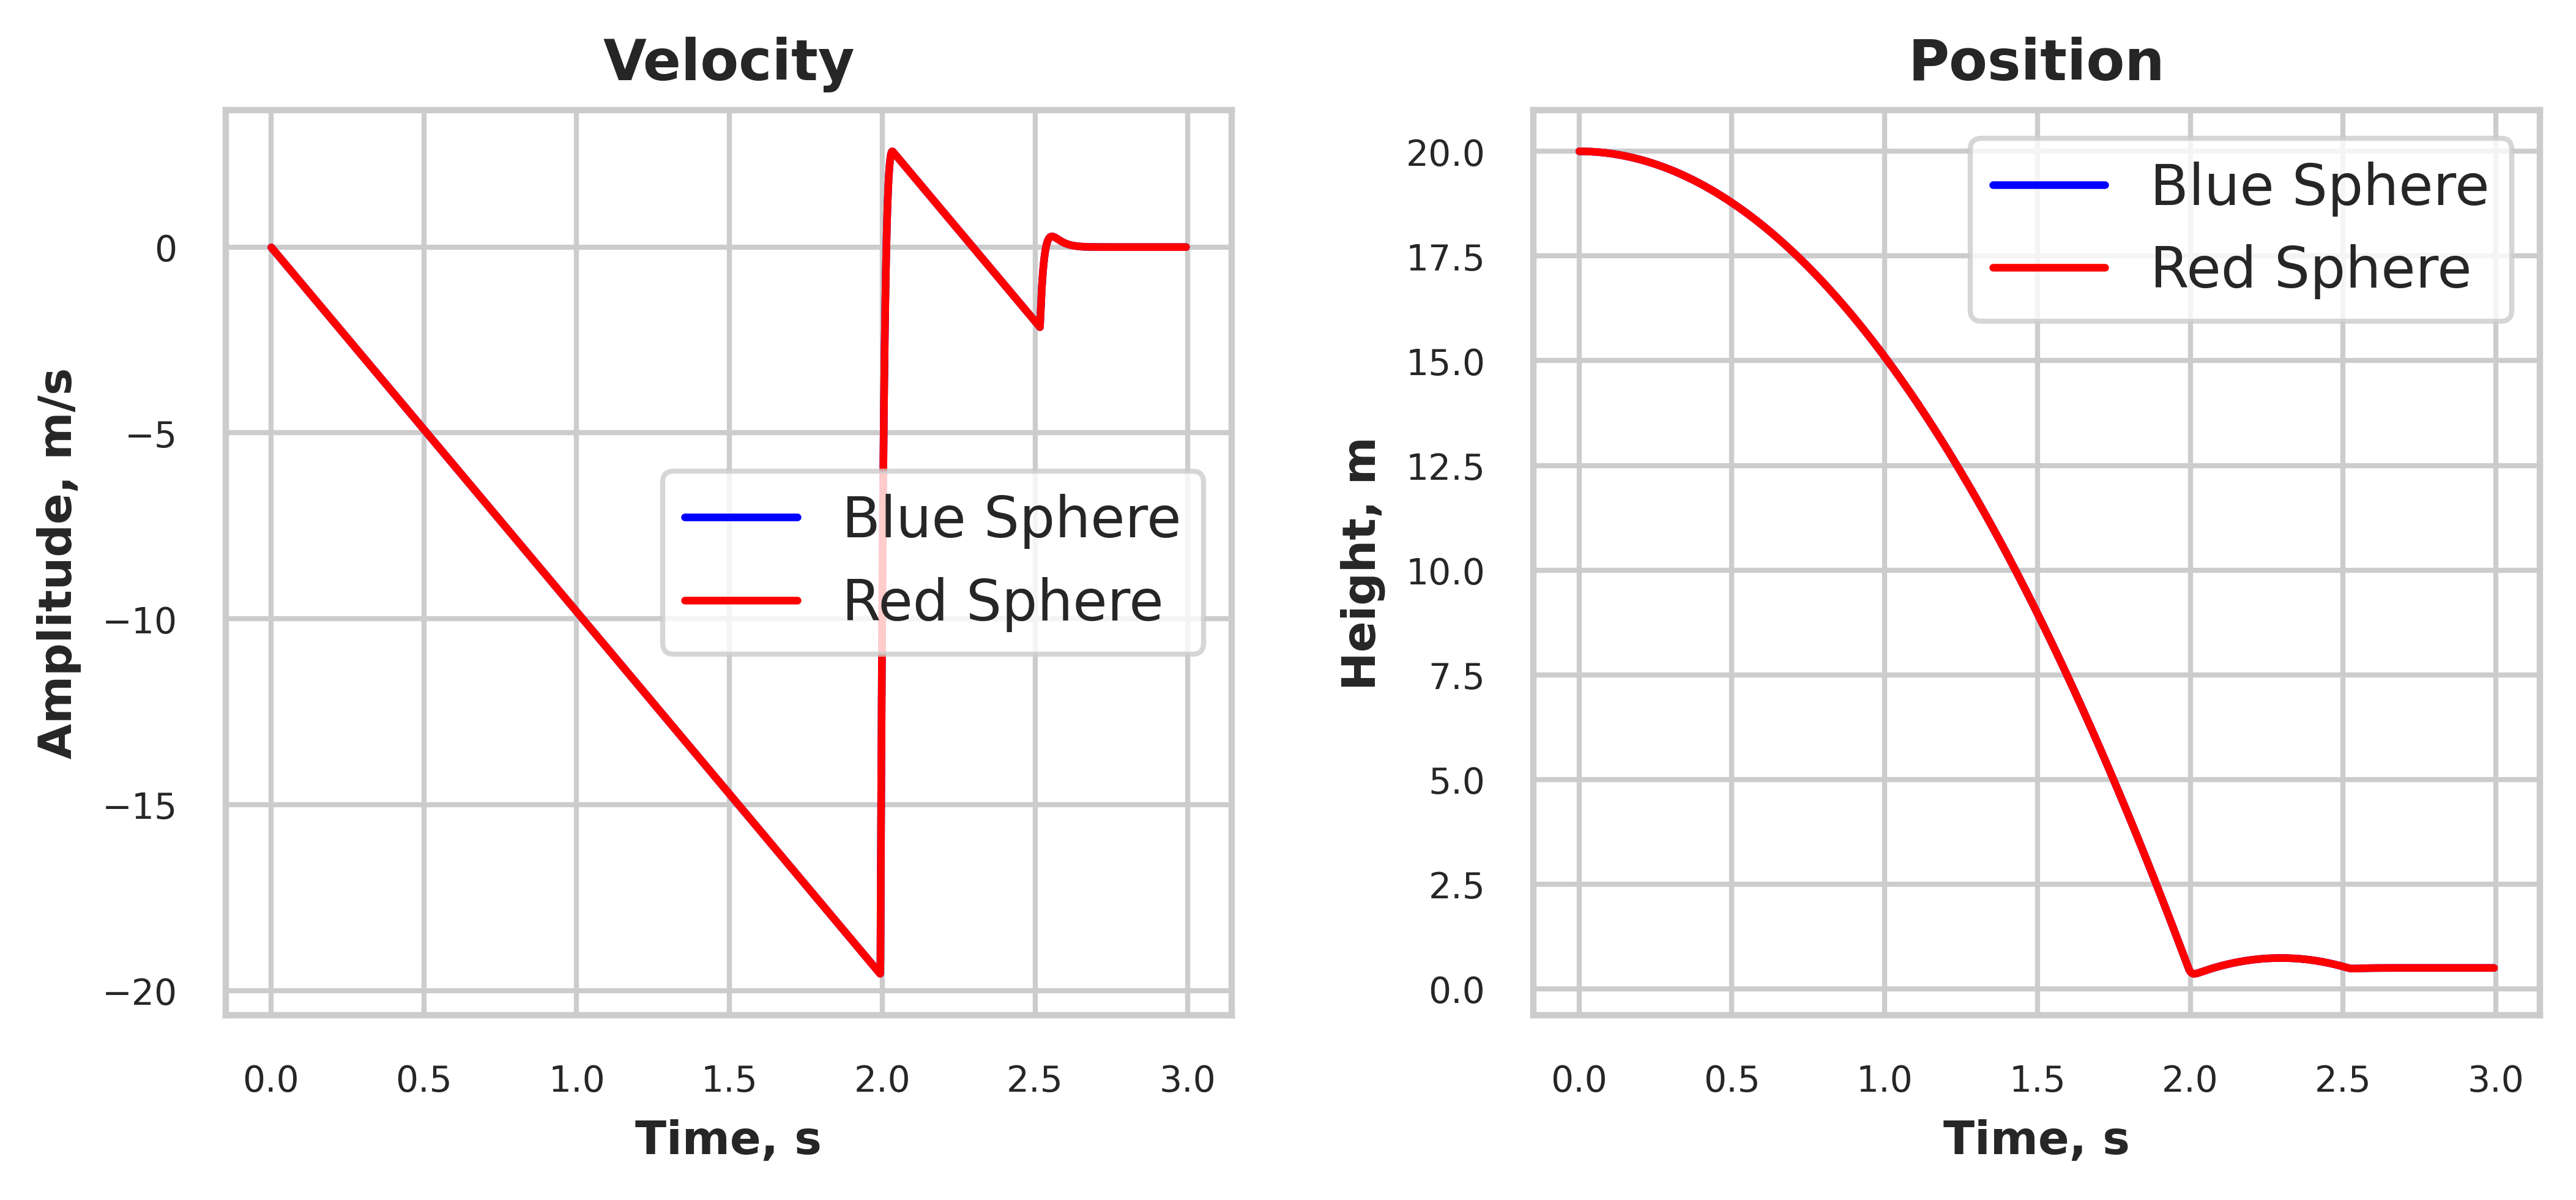

In [18]:
figsize = (width / dpi + 6, height / dpi + 2)
fig, ax = plt.subplots(ncols=2, figsize=figsize, dpi=dpi, sharex=False)
fig.subplots_adjust(wspace=0.3)

# position
sns.lineplot(x=timevals, y=blue_position, ax=ax[1], label="Blue Sphere", color="blue")
sns.lineplot(x=timevals, y=red_position, ax=ax[1], label="Red Sphere", color="red")
ax[1].set_title("Position", weight="bold", fontsize=11)
ax[1].set_ylabel("Height, m", weight="bold", fontsize=9)
ax[1].set_xlabel("Time, s", weight="bold", fontsize=9)
ax[1].tick_params(labelsize=7)

# velocity
sns.lineplot(x=timevals, y=blue_velocity, ax=ax[0], label="Blue Sphere", color="blue")
sns.lineplot(x=timevals, y=red_velocity, ax=ax[0], label="Red Sphere", color="red")
ax[0].set_title("Velocity", weight="bold", fontsize=11)
ax[0].set_ylabel("Amplitude, m/s", weight="bold", fontsize=9)
ax[0].set_xlabel("Time, s", weight="bold", fontsize=9)
ax[0].tick_params(labelsize=7)

chart_name = f"free_fall" if IS_COLAB else f"../../output/free_fall"
fig.savefig(chart_name + ".png", bbox_inches="tight")

In [20]:
red_velocity[2 * 1000]

np.float64(-8.53265349990099)

In [22]:
min(red_velocity)

np.float64(-19.55133000000043)